<a href="https://colab.research.google.com/github/dev-2k/text_reco/blob/main/BRATS_Brain_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/imcohen/segment-brain-mri.git

Cloning into 'segment-brain-mri'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 70 (delta 22), reused 53 (delta 13), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys 
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

In [3]:
%cd ~/../content/segment-brain-mri/notebooks/

/content/segment-brain-mri/notebooks


In [4]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
#write kaggle API credentials to kaggle.json
!echo '{"username":"pvsrivathsa","key":"9f4ebcfc78329e53654d1b180f7bf2ce"}' > ~/.kaggle/kaggle.json 
# set permissions
!chmod 600 ~/.kaggle/kaggle.json
#install the kaggle library
!pip install kaggle 
# download LGG Kaggle Dataset
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation -p ~/../content/segment-brain-mri/data/  
# unzip
!unzip -o ~/../content/segment-brain-mri/data/lgg-mri-segmentation.zip -d ~/../content/segment-brain-mri/data/

Streaming output truncated to the last 5000 lines.
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from skimage.measure import find_contours
from tqdm import tqdm

from sources.utils import plot_stack

In [6]:
data_path = '../data/kaggle_3m/'
df = pd.read_csv(os.path.join(data_path, 'data.csv'))

print('Number of patients : ', len(df))
print('Number of features : ', df.shape[1]-1)

Number of patients :  110
Number of features :  17


In [7]:
df.head()


,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


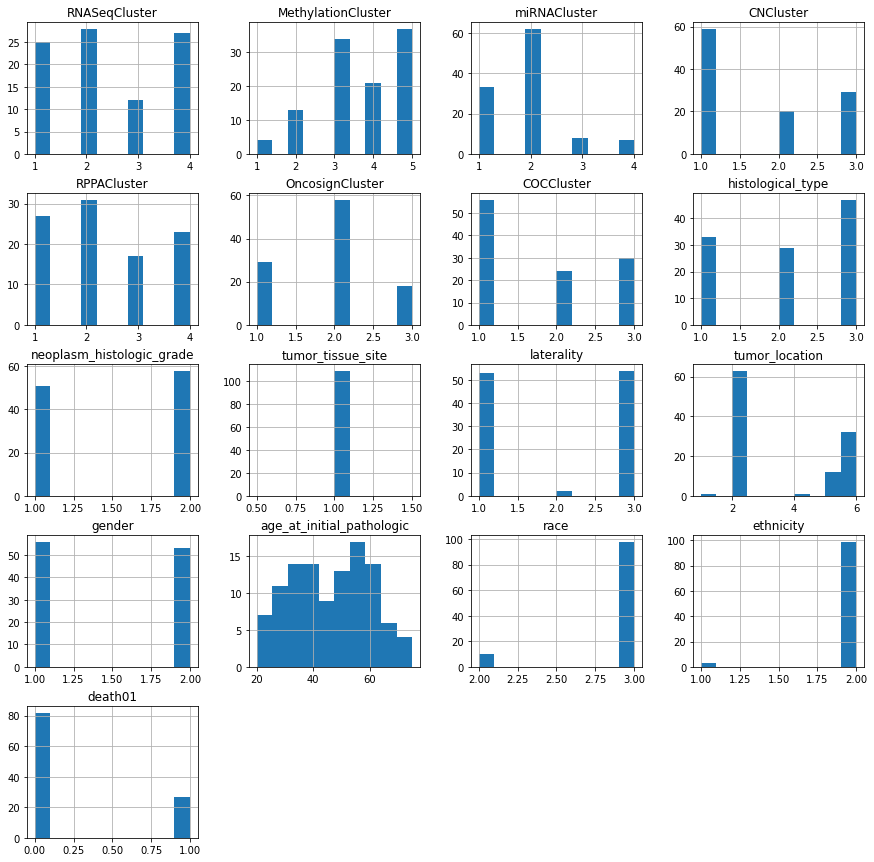

In [8]:
hist = df.hist(figsize=(15, 15))

In [9]:
image_df = pd.DataFrame(columns=['patient_id', 'image_id', 'image_path', 'mask_path', 'has_tumor'])

# patient directories
patient_dir = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
patient_dir.sort(key=lambda x:x[8:12]) # sort according to patient-ID

# if an image contains a non-empty tumor mask or not
def has_tumor(mask_path):
    mask = io.imread(mask_path)
    return int(np.sum(mask.ravel()) > 0)

# fill dataframe 
for d in tqdm(patient_dir):
    parent_dir = os.path.join(data_path, d)

    image_files = [f for f in os.listdir(parent_dir) if f.endswith('.tif') and not f.endswith('mask.tif')]
    image_key = lambda x:int(x[len(d)+1:].replace('.tif',''))
    image_files.sort(key=image_key) # sort according to ID of the image
    
    mask_files = [f for f in os.listdir(parent_dir) if f.endswith('mask.tif')]
    mask_key = lambda x:int(x[len(d)+1:].replace('_mask.tif',''))
    mask_files.sort(key=mask_key) # sort according to ID of the image
    
    for i, (image_file, mask_file) in enumerate(zip(image_files, mask_files)):
        if image_key(image_file) == mask_key(mask_file):
            image_df = image_df.append({'patient_id': d, 
                                        'image_id': image_key(image_file),
                                        'image_path': os.path.join(parent_dir, image_file),
                                        'mask_path': os.path.join(parent_dir, mask_file),
                                        'has_tumor': has_tumor(os.path.join(parent_dir, mask_file))},
                                       ignore_index=True)
        else:
            print("No corresponding mask found for image : ", image_file)

# save dataframe
image_df.to_csv('image_data.csv')

100%|██████████| 110/110 [00:23<00:00,  4.77it/s]


In [10]:
image_df = pd.read_csv('image_data.csv')    
print('Total number of images : ', len(image_df))
image_df.head()

Total number of images :  3929


,Unnamed: 0,patient_id,image_id,image_path,mask_path,has_tumor
0,0,TCGA_CS_4941_19960909,1,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,0
1,1,TCGA_CS_4941_19960909,2,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,0
2,2,TCGA_CS_4941_19960909,3,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,0
3,3,TCGA_CS_4941_19960909,4,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,0
4,4,TCGA_CS_4941_19960909,5,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,0


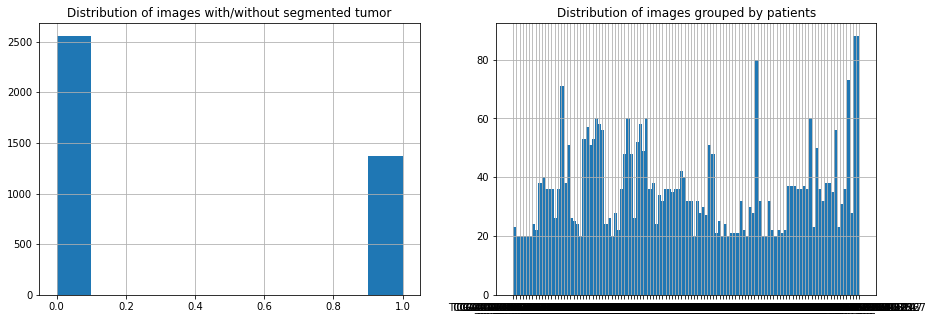

In [11]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(121)
hist = image_df['has_tumor'].hist()
plt.title("Distribution of images with/without segmented tumor")

plt.subplot(122)
hist = image_df['patient_id'].hist(bins=len(image_df['patient_id'].unique()))
plt.title("Distribution of images grouped by patients")

plt.show()

In [12]:
def read_mri(patient_id):
    sub_df = image_df[image_df.patient_id == patient_id].reset_index()
    dim = len(sub_df)
    image_stack = np.zeros((dim, 256, 256, 3), dtype='uint8')
    mask_stack = np.zeros((dim, 256, 256), dtype='uint8')
    for i in range(dim):
        image_stack[i] = io.imread(sub_df.image_path[i])
        mask_stack[i] = io.imread(sub_df.mask_path[i])
    return image_stack, mask_stack, list(sub_df[sub_df.has_tumor == 1].index)

# choose a patient
patient_index = 10
patient_id = image_df.patient_id.unique()[patient_index]

# read mri
image_stack, mask_stack, has_tumor_indices = read_mri(patient_id)

print("Patient ID : ", patient_id)
print("MRI stack : shape =", image_stack.shape, ", dtype =", image_stack.dtype)
print("Mask stack : shape =", mask_stack.shape, ", dtype =", mask_stack.dtype)
print("Indices of slices with segmented tumor :", has_tumor_indices)

Patient ID :  TCGA_DU_5852_19950709
MRI stack : shape = (36, 256, 256, 3) , dtype = uint8
Mask stack : shape = (36, 256, 256) , dtype = uint8
Indices of slices with segmented tumor : [11, 12, 13, 14, 15, 16, 17, 18]


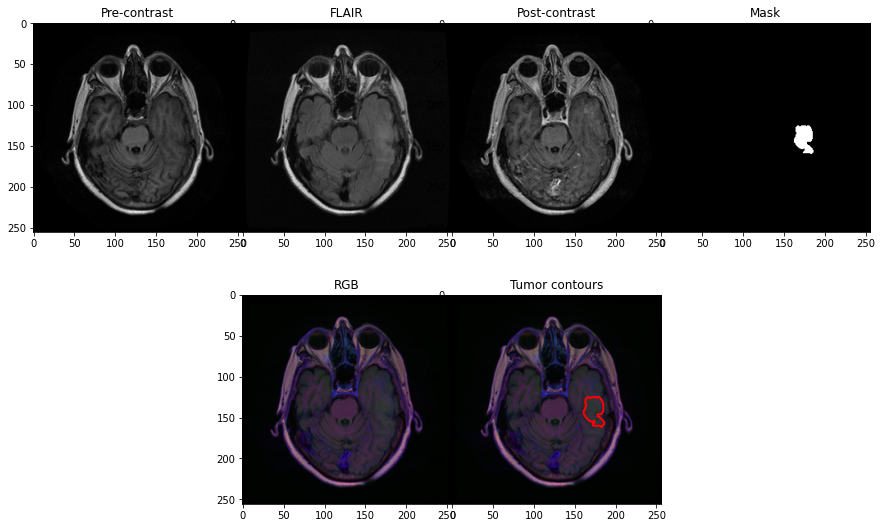

In [13]:
slice_index = 11
img_slice = image_stack[slice_index]
mask_slice = mask_stack[slice_index]

fig = plt.figure(figsize=(15, 10))

plt.subplot(241)
plt.imshow(img_slice[:, :, 0], 'gray'), plt.title("Pre-contrast")
plt.subplot(242)
plt.imshow(img_slice[:, :, 1], 'gray'), plt.title("FLAIR")
plt.subplot(243)
plt.imshow(img_slice[:, :, 2], 'gray'), plt.title("Post-contrast")
plt.subplot(244)
plt.imshow(mask_slice, 'gray'), plt.title("Mask")
plt.subplot(246)
plt.imshow(img_slice), plt.title("RGB")
plt.subplot(247)
plt.imshow(img_slice), 
contours = find_contours(mask_slice, 1)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
plt.title("Tumor contours")

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from skimage.measure import find_contours  
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data.dataloader import DataLoader
from torch.optim import Adam, lr_scheduler
from torch.nn import BCELoss
from tqdm import tqdm
from matplotlib.lines import Line2D

from sources.lgg_dataset import LGGDataset
from sources.unet import UNet

Number of images in training set :  2750
Number of images in validation set :  589
Number of images in test set :  590


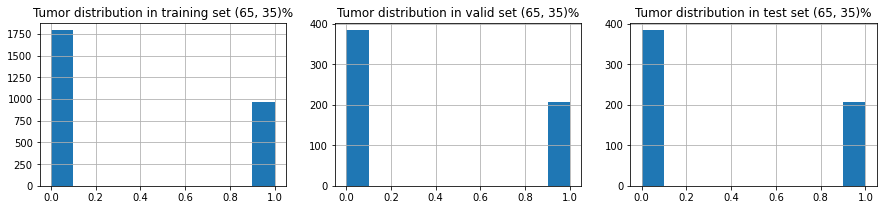

In [15]:
df = pd.read_csv("image_data.csv")

# prepare train/valid/test (70%-15%-15%) sets
train_df, temp_df = train_test_split(df, train_size=0.7, stratify=df.has_tumor, random_state=0)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, stratify=temp_df.has_tumor, random_state=0)

train_df = train_df.reset_index()
valid_df = valid_df.reset_index()
test_df = test_df.reset_index()

print('Number of images in training set : ', len(train_df))
print('Number of images in validation set : ', len(valid_df))
print('Number of images in test set : ', len(test_df))

# display distributions
def distribution(df):
    return (round(100*len(df[df.has_tumor==0])/len(df)), 
            round(100*len(df[df.has_tumor==1])/len(df))) 

fig = plt.figure(figsize=(15, 3))
plt.subplot(131), 
hist=train_df.has_tumor.hist(), 
plt.title('Tumor distribution in training set {0}%'.format(distribution(train_df)))
plt.subplot(132), valid_df.has_tumor.hist(), 
plt.title('Tumor distribution in valid set {0}%'.format(distribution(valid_df)))
plt.subplot(133), test_df.has_tumor.hist(), 
plt.title('Tumor distribution in test set {0}%'.format(distribution(test_df)))
plt.show()

In [16]:
# hyper-parameters
learning_rate = 1e-4
epochs = 10
batch_size = 2
device = 'cuda'

#random state for repeatable experiments
np.random.seed(0)
torch.manual_seed(0)

In [17]:
train_dataset = LGGDataset(train_df)
valid_dataset = LGGDataset(valid_df)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [18]:
model = UNet(in_channels=1, out_channels=1, init_features=32)

# weights initialization function
def init_weights(m):
  if type(m) == torch.nn.Conv2d:
    torch.nn.init.xavier_uniform_(m.weight)
  if type(m) == torch.nn.BatchNorm2d:
    torch.nn.init.uniform_(m.weight)
    torch.nn.init.constant_(m.bias, 0)

model.apply(init_weights)
model.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [19]:
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)

# loss
loss_function = BCELoss()

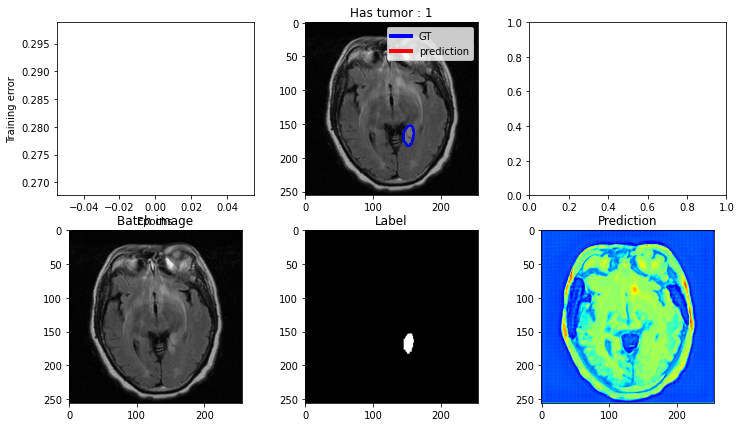

Epoch 2:  10%|█         | 1/10 [04:15<37:14, 248.29s/it, batch=35, avg_loss=0.152]

In [ ]:
%matplotlib inline
from IPython import display

# training loop
historic = {'loss': []}

fig, ax = plt.subplots(2, 3, figsize=(12, 7))
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4)]

pbar = tqdm(range(epochs), position=0, leave=True)
for epoch in pbar:  # loop over the dataset multiple times
    pbar.set_description('Epoch {0}'.format(epoch+1))
    
    ############ TRAINING ###########
    model.train()
    avg_loss = 0

    for i, data in enumerate(train_dataloader):
        # get the inputs
        image, mask = data

        image = image.to(device)
        mask = mask.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = model(image)
        loss = loss_function(prediction, mask)
        loss.backward()
        optimizer.step()

        # print 
        avg_loss += loss.item()
        pbar.set_postfix({'batch': i+1,
                          'avg_loss': loss.item()})
        if i%100==0:
          # display
          image_numpy = np.squeeze(image[0]).data.cpu().numpy()
          mask_numpy = np.squeeze(mask[0]).data.cpu().numpy()
          has_tumor = int(np.sum(mask_numpy.ravel()) > 0)
          predict_mask_numpy = np.squeeze(prediction[0]).data.cpu().numpy()>0.5
          ax[0, 1].clear(), ax[0, 1].imshow(image_numpy, 'gray')
          ax[0, 1].contour(mask_numpy, colors='b')
          ax[0, 1].contour(predict_mask_numpy, colors='r')
          ax[0, 1].set_title("Has tumor : {0}".format(has_tumor))
          ax[0, 1].legend(custom_lines, ['GT', 'prediction'])
          ax[1, 0].clear(), ax[1, 0].imshow(image_numpy, 'gray'), ax[1, 0].set_title("Batch image")
          ax[1, 1].clear(), ax[1, 1].imshow(mask_numpy, 'gray'), ax[1, 1].set_title("Label")
          ax[1, 2].clear(), ax[1, 2].imshow(np.squeeze(prediction[0]).data.cpu().numpy(), 'jet'), 
          ax[1, 2].set_title("Prediction")
          display.clear_output(wait=True)
          display.display(plt.gcf())

    historic['loss'].append(avg_loss/len(train_dataloader))
    ax[0, 0].clear(), ax[0, 0].plot(historic['loss'])
    ax[0, 0].set_ylabel("Training error"), ax[0, 0].set_xlabel("Epochs")

    ############ VALIDATION ###########
    #model.eval()
    
print('Finished Training')